# Checking the improvement of AnEn-CNN hybrid

In [1]:
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/fcstpp/')

from fcstpp import metrics
import analog_utils as ana
import graph_utils as gu
import data_utils as du

from namelist import * 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Importing data

In [3]:
prefix_cnn = 'BASE_CNN'
prefix_ens = 'BASE_final_SS'

EN = 25
year = 2017
lead = 10

In [4]:
# land_mask and water shed
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    land_mask_bc = h5io['land_mask_bc'][...]
grid_shape = land_mask_bc.shape

with h5py.File(save_dir+'BCH_wshed_groups.hdf', 'r') as h5io:
    flag_sw = h5io['flag_sw'][...]
    flag_si = h5io['flag_si'][...]
    flag_n = h5io['flag_n'][...]
    
FLAGs = (flag_sw, flag_si, flag_n)

In [5]:
# Ours
with h5py.File(REFCST_dir+'{}_{}_lead{}.hdf'.format(prefix_cnn, year, lead), 'r') as h5io:
    AnEn_fit = h5io['cnn_pred'][...]
AnEn_fit = ana.cnn_precip_fix(AnEn_fit)

# AnEn (Hamill 2015)
with h5py.File(REFCST_dir+'{}_{}_lead{}.hdf'.format(prefix_ens, year, lead), 'r') as h5io:
    AnEn_full_ = h5io['AnEn'][:, :EN, ...]
    
AnEn_full = np.empty((365, EN)+grid_shape); AnEn_full[...] = np.nan
AnEn_full[..., ~land_mask_bc] = AnEn_full_

In [6]:
# Observations
with h5py.File(save_dir+'BCH_ERA5_3H_verif.hdf', 'r') as h5io:
    BCH_obs = h5io['BCH_obs'][...]
    ERA5_obs = h5io['ERA5_obs'][...]
    indx = h5io['indx'][...]
    indy = h5io['indy'][...]
    
# subsetting BCH obs into a given year
N_days = 366 + 365*3
date_base = datetime(2016, 1, 1)
date_list = [date_base + timedelta(days=x) for x in np.arange(N_days, dtype=np.float)]

flag_pick = []
for date in date_list:
    if date.year == year:
        flag_pick.append(True)
    else:
        flag_pick.append(False)

flag_pick = np.array(flag_pick)
    
BCH_obs = BCH_obs[flag_pick, ...] # <----- Verify against BCH
ERA5_obs = ERA5_obs[flag_pick, ...]

# Deterministic scores

In [7]:
cnn_mean = np.nanmean(AnEn_fit, axis=1)
AnEn_mean = np.nanmean(AnEn_full, axis=1)

cnn_mean_stn = cnn_mean[:, indx, indy]
AnEn_mean_stn = AnEn_mean[:, indx, indy]

print(np.nanmean(np.abs(BCH_obs[:, lead, :]-cnn_mean_stn)))
print(np.nanmean(np.abs(BCH_obs[:, lead, :]-AnEn_mean_stn)))

0.40996925208511475
0.43240568744661045


In [8]:
ytrue = BCH_obs[:, lead, :]>1.4
ypred = cnn_mean_stn>1.4

ytrue[np.isnan(BCH_obs[:, lead, :])] = np.nan

metrics.ETS(ytrue.ravel(), ypred.ravel())

0.16953963952884613

In [9]:
ytrue = BCH_obs[:, lead, :]>1.4
ypred = AnEn_mean_stn>1.4

ytrue[np.isnan(BCH_obs[:, lead, :])] = np.nan

metrics.ETS(ytrue.ravel(), ypred.ravel())

0.1489465563253799

# Ensemble scores

In [10]:
AnEn_fit_stn = AnEn_fit[..., indx, indy]
AnEn_full_stn = AnEn_full[..., indx, indy]

In [11]:
CRPS_fit, MAE_fit, SPREAD_fit = metrics.CRPS_1d_nan(BCH_obs[:, lead, :], AnEn_fit_stn[...])
CRPS_stn, MAE_stn, SPREAD_stn = metrics.CRPS_1d_nan(BCH_obs[:, lead, :], AnEn_full_stn[...])

print('CRPS: {}, {}'.format(np.nanmean(CRPS_fit), np.nanmean(CRPS_stn)))
print('MAE: {}, {}'.format(np.nanmean(MAE_fit), np.nanmean(MAE_stn)))
print('SPREAD: {}, {}'.format(np.nanmean(SPREAD_fit), np.nanmean(SPREAD_stn)))

CRPS: 0.29295719242190377, 0.3135904969737336
MAE: 0.5094635188364008, 0.49256064449639714
SPREAD: 0.21650632641449696, 0.17897014752266355


In [12]:
print(np.nanmean(np.abs(BCH_obs[:, lead, :]-np.nanmean(AnEn_fit_stn, axis=1))))
print(np.nanmean(np.abs(BCH_obs[:, lead, :]-np.nanmean(AnEn_full_stn, axis=1))))

0.40996925208511475
0.43240568744661045


# Exploratory data analysis

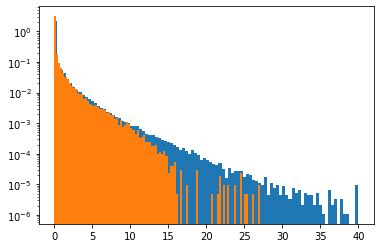

In [13]:
plt.hist(AnEn_fit_stn.ravel(), bins=100, log=True, density=True);
plt.hist(AnEn_full_stn.ravel(), bins=100, log=True, density=True);

In [14]:
cmap_pct, A = gu.precip_cmap()

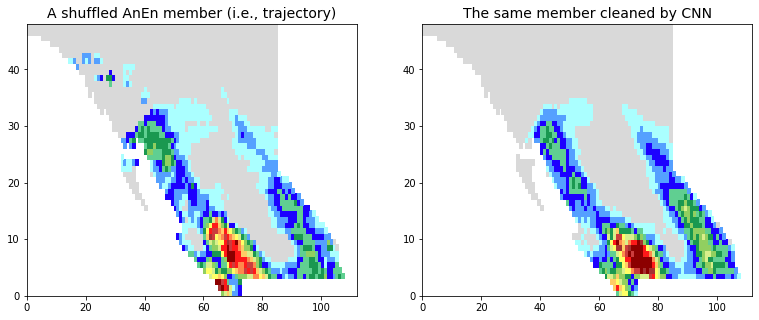

In [15]:
plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.pcolormesh(AnEn_full[16, 3, ...], vmin=0, vmax=10, cmap=cmap_pct)
plt.title("A shuffled AnEn member (i.e., trajectory)", fontsize=14)

plt.subplot(122)
plt.pcolormesh(AnEn_fit[16, 5, ...], vmin=0, vmax=10, cmap=cmap_pct)
plt.title("The same member cleaned by CNN", fontsize=14);

**Conclusions**

* AnEn-CNN is more skill full, provides a better-organised precipitation intensity spectra, and is spatially more realistic.